# 1.bis. CBoW demo (Short text)

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (19/03/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Torch (tested on v1.10.1)
- Torchvision (tested on v0.11.2)
- We also strongly recommend setting up CUDA on your machine!

### Imports

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

### Step 1. Produce some data based on a given text for training our CBoW model    

In [2]:
def text_to_train(text, context_window):
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        context = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        target = text[i]
        data.append((context, target))
        
    return data

In [3]:
def create_text():
    
    # Load corpus from file
    with open("./text_short.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [4]:
text = create_text()
print(text)

['i', 'would', 'be', 'fatal', 'for', 'the', 'nation', 'to', 'overlook', 'the', 'urgency', 'of', 'the', 'moment', 'and', 'to', 'underestimate', 'the', 'determination', 'of', 'its', 'colored', 'citizens', 'this', 'sweltering', 'summer', 'of', 'the', 'colored', 'peoples', 'legitimate', 'discontent', 'will', 'not', 'pass', 'until', 'there', 'is', 'an', 'invigorating', 'autumn', 'of', 'freedom', 'and', 'equality', 'nineteen', 'sixtythree', 'is', 'not', 'an', 'end', 'but', 'a', 'beginning', 'those', 'who', 'hope', 'that', 'the', 'colored', 'americans', 'needed', 'to', 'blow', 'off', 'steam', 'and', 'will', 'now', 'be', 'content', 'will', 'have', 'a', 'rude', 'awakening', 'if', 'the', 'nation', 'returns', 'to', 'business', 'as', 'usual', 'there', 'will', 'be', 'neither', 'rest', 'nor', 'tranquility', 'in', 'america', 'until', 'the', 'colored', 'citizen', 'is', 'granted', 'his', 'citizenship', 'rights', 'the', 'whirlwinds', 'of', 'revolt', 'will', 'continue', 'to', 'shake', 'the', 'foundations

In [5]:
def generate_data(text, context_window):
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [6]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [7]:
print(vocab)

{'with', 'blow', 'their', 'believes', 'changed', 'american', 'heat', 'in', 'larger', 'children', 'by', 'back', 'redemptive', 'my', 'have', 'neither', 'new', 'which', 'georgia', 'there', 'transformed', 'its', 'awakening', 'am', 'alabama', 'off', 'colored', 'robbed', 'only', 'friends', 'those', 'determination', 'four', 'down', 'steam', 'knowing', 'invigorating', 'situation', 'staggered', 'would', 'pass', 'citizenship', 'summer', 'where', 'been', 'true', 'meaning', 'business', 'rights', 'sit', 'dream', 'underestimate', 'stream', 'table', 'today', 'come', 'is', 'overlook', 'the', 'men', 'some', 'travel', 'brutality', 'character', 'winds', 'smaller', 'into', 'creative', 'discontent', 'autumn', 'skin', 'tranquility', 'wallow', 'red', 'fatal', 'these', 'hope', 'left', 'former', 'south', 'his', 'oasis', 'quest', 'judged', 'hills', 'sons', 'peoples', 'police', 'deeply', 'despair', 'shake', 'not', 'waters', 'stripped', 'nothing', 'fatigue', 'they', 'rooted', 'able', 'slaveowners', 'persons', 'be

In [8]:
print(word2index)

{'with': 0, 'blow': 1, 'their': 2, 'believes': 3, 'changed': 4, 'american': 5, 'heat': 6, 'in': 7, 'larger': 8, 'children': 9, 'by': 10, 'back': 11, 'redemptive': 12, 'my': 13, 'have': 14, 'neither': 15, 'new': 16, 'which': 17, 'georgia': 18, 'there': 19, 'transformed': 20, 'its': 21, 'awakening': 22, 'am': 23, 'alabama': 24, 'off': 25, 'colored': 26, 'robbed': 27, 'only': 28, 'friends': 29, 'those': 30, 'determination': 31, 'four': 32, 'down': 33, 'steam': 34, 'knowing': 35, 'invigorating': 36, 'situation': 37, 'staggered': 38, 'would': 39, 'pass': 40, 'citizenship': 41, 'summer': 42, 'where': 43, 'been': 44, 'true': 45, 'meaning': 46, 'business': 47, 'rights': 48, 'sit': 49, 'dream': 50, 'underestimate': 51, 'stream': 52, 'table': 53, 'today': 54, 'come': 55, 'is': 56, 'overlook': 57, 'the': 58, 'men': 59, 'some': 60, 'travel': 61, 'brutality': 62, 'character': 63, 'winds': 64, 'smaller': 65, 'into': 66, 'creative': 67, 'discontent': 68, 'autumn': 69, 'skin': 70, 'tranquility': 71, '

In [9]:
print(index2word)

{0: 'with', 1: 'blow', 2: 'their', 3: 'believes', 4: 'changed', 5: 'american', 6: 'heat', 7: 'in', 8: 'larger', 9: 'children', 10: 'by', 11: 'back', 12: 'redemptive', 13: 'my', 14: 'have', 15: 'neither', 16: 'new', 17: 'which', 18: 'georgia', 19: 'there', 20: 'transformed', 21: 'its', 22: 'awakening', 23: 'am', 24: 'alabama', 25: 'off', 26: 'colored', 27: 'robbed', 28: 'only', 29: 'friends', 30: 'those', 31: 'determination', 32: 'four', 33: 'down', 34: 'steam', 35: 'knowing', 36: 'invigorating', 37: 'situation', 38: 'staggered', 39: 'would', 40: 'pass', 41: 'citizenship', 42: 'summer', 43: 'where', 44: 'been', 45: 'true', 46: 'meaning', 47: 'business', 48: 'rights', 49: 'sit', 50: 'dream', 51: 'underestimate', 52: 'stream', 53: 'table', 54: 'today', 55: 'come', 56: 'is', 57: 'overlook', 58: 'the', 59: 'men', 60: 'some', 61: 'travel', 62: 'brutality', 63: 'character', 64: 'winds', 65: 'smaller', 66: 'into', 67: 'creative', 68: 'discontent', 69: 'autumn', 70: 'skin', 71: 'tranquility', 7

In [10]:
print(data)

[(['i', 'would', 'fatal', 'for'], 'be'), (['would', 'be', 'for', 'the'], 'fatal'), (['be', 'fatal', 'the', 'nation'], 'for'), (['fatal', 'for', 'nation', 'to'], 'the'), (['for', 'the', 'to', 'overlook'], 'nation'), (['the', 'nation', 'overlook', 'the'], 'to'), (['nation', 'to', 'the', 'urgency'], 'overlook'), (['to', 'overlook', 'urgency', 'of'], 'the'), (['overlook', 'the', 'of', 'the'], 'urgency'), (['the', 'urgency', 'the', 'moment'], 'of'), (['urgency', 'of', 'moment', 'and'], 'the'), (['of', 'the', 'and', 'to'], 'moment'), (['the', 'moment', 'to', 'underestimate'], 'and'), (['moment', 'and', 'underestimate', 'the'], 'to'), (['and', 'to', 'the', 'determination'], 'underestimate'), (['to', 'underestimate', 'determination', 'of'], 'the'), (['underestimate', 'the', 'of', 'its'], 'determination'), (['the', 'determination', 'its', 'colored'], 'of'), (['determination', 'of', 'colored', 'citizens'], 'its'), (['of', 'its', 'citizens', 'this'], 'colored'), (['its', 'colored', 'this', 'swelt

In [11]:
def words_to_tensor(words: list, w2i: dict, dtype = torch.FloatTensor):
    tensor =  dtype([w2i[word] for word in words])
    tensor = tensor.to(device)
    return Variable(tensor)

### Step 2. Create a CBoW model and train

In [12]:
class CBOW(nn.Module):

    def __init__(self, context_size, embedding_size, vocab_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        lookup_embeds = self.embeddings(inputs)
        embeds = lookup_embeds.sum(dim = 0)
        out = self.linear(embeds)
        #out = F.log_softmax(out, dim = -1)
        return out

In [13]:
# Create model and pass to CUDA
model = CBOW(context_size = 2, embedding_size = 20, vocab_size = len(vocab))
model = model.to(device)
model.train()

CBOW(
  (embeddings): Embedding(236, 20)
  (linear): Linear(in_features=20, out_features=236, bias=True)
)

In [14]:
# Define training parameters
learning_rate = 0.001
epochs = 500
torch.manual_seed(28)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
def get_prediction(context, model, word2index, index2word):
    
    # Get into eval() mode
    model.eval()
    ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
    
    # Forward pass
    prediction = model(ids)
    # Reshape to cover for absence of minibatches (needed for loss function)
    prediction = torch.reshape(prediction, (1, 236))
    _, index = torch.max(prediction, 1)
    
    return index2word[index.item()]

In [16]:
def check_accuracy(model, data, word2index, index2word):
    
    # Compute accuracy
    correct = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)
        if prediction == target:
            correct += 1
            
    return correct/len(data)

In [17]:
losses = []
accuracies = []

for epoch in range(epochs):
    total_loss = 0
    
    for context, target in data:
        
        # Prepare data
        ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
        target = words_to_tensor([target], word2index, dtype = torch.LongTensor)
        
        # Forward pass
        model.zero_grad()
        output = model(ids)
        # Reshape to cover for absence of minibatches (needed for loss function)
        output = torch.reshape(output, (1, 236))
        loss = loss_func(output, target)
        
        # Backward pass and optim
        loss.backward()
        optimizer.step()
        
        # Loss update
        total_loss += loss.data.item()
    
    # Display
    if epoch % 10 == 0:
        accuracy = check_accuracy(model, data, word2index, index2word)
        print("Accuracy after epoch {} is {}".format(epoch, accuracy))
        accuracies.append(accuracy)
        losses.append(total_loss)

Accuracy after epoch 0 is 0.0037735849056603774
Accuracy after epoch 10 is 0.16792452830188678
Accuracy after epoch 20 is 0.24150943396226415
Accuracy after epoch 30 is 0.3018867924528302
Accuracy after epoch 40 is 0.3339622641509434
Accuracy after epoch 50 is 0.3641509433962264
Accuracy after epoch 60 is 0.4056603773584906
Accuracy after epoch 70 is 0.469811320754717
Accuracy after epoch 80 is 0.5
Accuracy after epoch 90 is 0.5452830188679245
Accuracy after epoch 100 is 0.5849056603773585
Accuracy after epoch 110 is 0.6339622641509434
Accuracy after epoch 120 is 0.6698113207547169
Accuracy after epoch 130 is 0.6981132075471698
Accuracy after epoch 140 is 0.7320754716981132
Accuracy after epoch 150 is 0.7471698113207547
Accuracy after epoch 160 is 0.7679245283018868
Accuracy after epoch 170 is 0.7943396226415095
Accuracy after epoch 180 is 0.8132075471698114
Accuracy after epoch 190 is 0.8207547169811321
Accuracy after epoch 200 is 0.8283018867924529
Accuracy after epoch 210 is 0.84905

### 3. Visualization

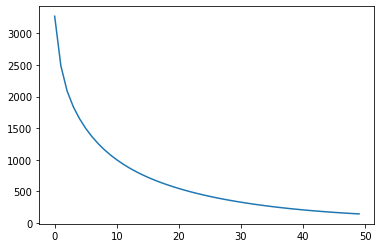

In [18]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

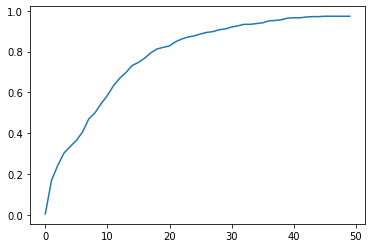

In [19]:
# Display accuracy over time
plt.figure()
plt.plot(accuracies)
plt.show()

In [21]:
word1 = words_to_tensor(["americans"], word2index, dtype = torch.LongTensor)
word2 = words_to_tensor(["citizens"], word2index, dtype = torch.LongTensor)
word3 = words_to_tensor(["carolina"], word2index, dtype = torch.LongTensor)
w1 = torch.reshape(model.embeddings(word1), (20,))
w2 = torch.reshape(model.embeddings(word2), (20,))
w3 = torch.reshape(model.embeddings(word3), (20,))
print(w1)
print(w2)
print(w3)

tensor([-1.6450,  0.8511, -0.3467,  0.8812,  0.9119,  0.6175, -0.5443, -0.8703,
        -0.8517, -0.6817, -2.2370, -0.1208, -0.6038,  0.2638, -0.8582, -1.5242,
         0.5613,  1.8142, -1.6308, -1.0429], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([-0.3242, -2.1802,  1.5109,  0.4658, -0.9882, -1.4752,  0.3500,  0.0118,
         0.2830,  0.4404, -0.4376,  0.4814, -0.3231, -0.0064, -0.5311, -0.3680,
         0.4956, -0.3300,  4.0978, -0.1567], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([-1.5293, -2.2764, -1.0427, -1.5378,  1.8322,  0.2097, -1.1337, -0.0944,
        -1.3564,  1.1539,  0.5919, -2.1171,  0.2877,  0.0955, -0.2998, -1.1962,
         0.6276,  0.1575, -1.9254,  0.6729], device='cuda:0',
       grad_fn=<ViewBackward>)
